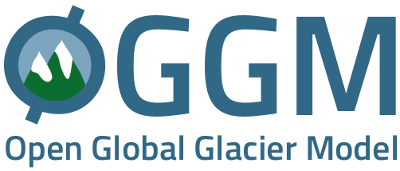

# Ice thickness inversion with frontal ablation: a case study

In this notebook we are illustrating how OGGM searches for a frontal calving flux which is compatible with mass conservation, ice thickness estimation based on Glen's flow law, and the calving parameterization of [Oerlemans and Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F).

For more details, see [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/).

## Set-up

These are the usual OGGM workflow commands.

In [2]:
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics

In [4]:
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Calving', reset=True)
cfg.PARAMS['border'] = 10

2019-02-20 14:04:31: oggm.cfg: Using configuration file: /home/bea/Hackathon/oggm/oggm/params.cfg


## Pick a glacier 

Here we experiment with Leconte glacier (`RGI60-01.03622`). But you can try with other glaciers as well!

In [5]:
gdir = workflow.init_glacier_regions(['RGI60-01.03622'], from_prepro_level=3)[0]

2019-02-20 14:04:47: oggm.workflow: init_glacier_regions from prepro level 3 on 1 glaciers.
2019-02-20 14:04:47: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2019-02-20 14:04:47: oggm.workflow: Multiprocessing: using all available processors (N=4)


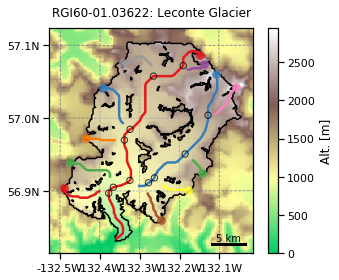

In [6]:
graphics.plot_centerlines(gdir, use_flowlines=True);

**Let's first see the results of the inversion without calving:**

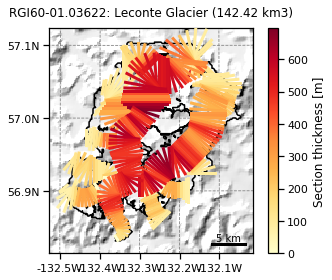

In [8]:
graphics.plot_inversion(gdir);

## The basic principles

We use a simple calving law borrowed from [Oerlemans and Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F), which relates the frontal calving flux $F_{calving}$ to the frontal ice thickness $H_f$, the water depth $d$ and the terminus width $w$

$$F_{calving} = k H_f d w$$

With $F_{calving}$ in km$^3$ yr$^{-1}$, $k$ a calibration parameter (default 2.4 yr$^{-1}$) and $d =$ $H_{f}$ - $E_{t}$ ($E_{t}$ being the free board).

As explained in [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/), ice conservation methods applied to tidewater glaciers *must* take into account this mass-flux at the terminus, otherwise the ice thickness is underestimated. In fact, the default OGGM ice thickness inversion procedure assumes an ice flux of zero at the terminus: 

In [11]:
# Default calving flux:
utils.calving_flux_from_depth(gdir)

{'flux': -0.0,
 'width': 775.0304918212076,
 'thick': 0.0,
 'water_depth': -84.02454858723632,
 'free_board': 84.02454858723632}

Here, `flux` is the calving flux ($F_{calving}$) in km$^3$ yr$^{-1}$, `free_board` is the height of ice above water ($E_{t}$, i.e. above 0 m a.s.l), `thick` the frontal ice thickness ($H_{f}$) in m (equal to zero per construction in OGGM), `water_depth` the water depth in m (negative here because of the zero ice thickness and a terminus elevation equal to the freeboard imply a positive bedrock elevation), `width` the front width in m.

Now let's see how this calving flux would change if we increase the ice thickness (while keeping the free board fixed, because this is the only thing we know "for sure": the surface elevation at the terminus.):

In [12]:
df = []
for thick in np.linspace(0, 500, 51):
    # This function simply computes the calving law
    df.append(utils.calving_flux_from_depth(gdir, thick=thick))
df = pd.DataFrame(df).set_index('thick')

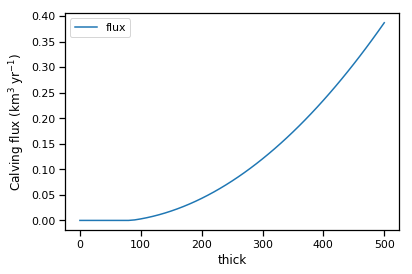

In [13]:
df[['flux']].plot();
plt.ylabel('Calving flux (km$^3$ yr$^{-1}$)');

The flux is zero as long as the ice isn't thick enough to reach water, after which the water depth is positive and calving occurs. The calving flux varies with $H$ as a polynomial of degree 2.

We don't know which is the **real** value of the calving flux at this glacier. From here, let's make some very coarse assumptions:
- the Oerlemans and Nick calving law is perfectly exact
- the tuning parameter $k$ is known
- our glacier is in equilibrium (a fundamental assumption for mass-conservation inversion)
- ice flow at the front follows Glen's flow law

Under these assumptions, we are now going to show, that there is **one and only one** value for the frontal thickness which complies with *both* the calving law and the ice thickness inversion model of OGGM.

To test this hypothesis, we are going to compute a calving flux (from the calving law) for a range of frontal ice thicknesses, then give this flux back to the OGGM inversion model, which will use this flux to compute the frontal ice thickness according to the physics of ice flow (see the [documentation](https://docs.oggm.org/en/latest/inversion.html) or [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/) for more info). Let's see how this works:

In [15]:
df = []
for thick in np.linspace(0, 500, 51):
    # This function simply computes the calving law
    out = utils.calving_flux_from_depth(gdir, thick=thick)
    out['thick (prescribed)'] = out.pop('thick')
    
    # Now we feed it back to OGGM
    gdir.inversion_calving_rate = out['flux']
    
    # The mass-balance has to adapt in order to create a flux
    tasks.local_t_star(gdir)    
    tasks.mu_star_calibration(gdir)
    tasks.prepare_for_inversion(gdir)
    v_inv, _ = tasks.mass_conservation_inversion(gdir)
    
    # Now we get the OGGM ice thickness 
    out['thick (oggm)'] = utils.calving_flux_from_depth(gdir)['thick']
    
    # Add sliding (the fs value is outdated, but still)
    v_inv, _ = tasks.mass_conservation_inversion(gdir, fs=5.7e-20)
    out['thick (oggm+sliding)'] = utils.calving_flux_from_depth(gdir)['thick']
    
    # Store
    df.append(out)
    
df = pd.DataFrame(df)

We've got:

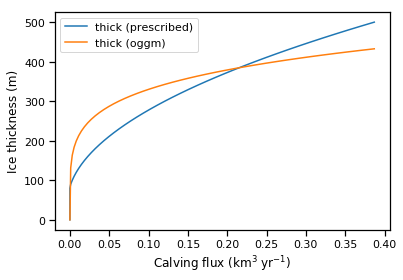

In [16]:
df[['flux', 'thick (prescribed)', 'thick (oggm)']].plot(x='flux');
plt.xlabel('Calving flux (km$^3$ yr$^{-1}$)');
plt.ylabel('Ice thickness (m)');

We already know that the calving law relates the thickness to the flux with a root of degree two (blue curve). Now, what explains the shape of **the orange curve** (OR BLUE??)? It is Glen's flow law, which relates ice thickness to the flux with a 5th degree root (assuming n=3). This is the reason why there is one (and only one) non-zero solution to the problem of finding a calving flux which is compatible with both the calving law and the physics of ice deformation (under our simplified framework of course).

Note that adding sliding doesn't change the problem (we still solve a polynome of degree 5 in OGGM, [with a new term in degree 3](https://docs.oggm.org/en/latest/ice-dynamics.html)):

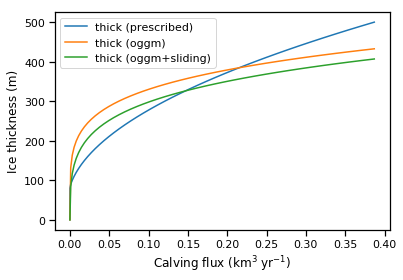

In [17]:
df[['flux', 'thick (prescribed)', 'thick (oggm)', 'thick (oggm+sliding)']].plot(x='flux');
plt.xlabel('Calving flux (km$^3$ yr$^{-1}$)');
plt.ylabel('Ice thickness (m)');   

## Finding the optimum frontal thickness 

There are several ways to find this "optimal" thickness, where mass-conservation inversion and the calving law are compatible. In OGGM, we implement an iterative procedure converging to this value in a few iterations:

In [18]:
df = utils.find_inversion_calving(gdir)

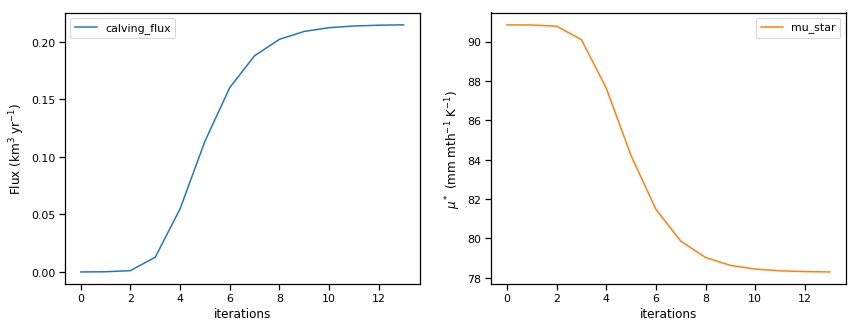

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
df[['calving_flux']].plot(ax=ax1);
ax1.set_ylabel('Flux (km$^3$ yr$^{-1}$)');
df[['mu_star']].plot(ax=ax2, color='C1');
ax2.set_ylabel('$\mu^*$ (mm mth$^{-1}$ K$^{-1}$)');

The procedure starts with an initial water depth of 1 m, then iteratively feeds the calving flux back to the mass-conservation inversion function of OGGM, which adapts the mass-balance model to cope with a non-zero ice flux at the front. In order to do that, the temperature sensitivity $\mu^*$ has to be reduced (per construction, the original $\mu^*$ is defined such that the flux at the front is zero).

Convergence is reached when the OGGM flux equals the calving law flux within 0.1%:

In [20]:
print('At convergence:')
print(df.iloc[-1])

At convergence:
calving_flux          0.214786
mu_star              78.298964
calving_law_flux      0.214928
width               775.030492
thick               384.522048
water_depth         300.497499
free_board           84.024549
Name: 13, dtype: float64


### Sensitivity to the initial guess 

The method always converges, regardless of the starting water depth:

In [21]:
df = pd.DataFrame()
df['wd_001'] = utils.find_inversion_calving(gdir, water_depth=1)['calving_flux']
df['wd_100'] = utils.find_inversion_calving(gdir, water_depth=100)['calving_flux']
df['wd_200'] = utils.find_inversion_calving(gdir, water_depth=200)['calving_flux']
df['wd_300'] = utils.find_inversion_calving(gdir, water_depth=300)['calving_flux']
df['wd_400'] = utils.find_inversion_calving(gdir, water_depth=400)['calving_flux']
df['wd_500'] = utils.find_inversion_calving(gdir, water_depth=500)['calving_flux']

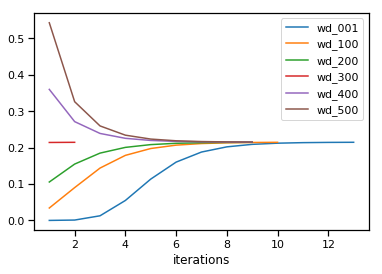

In [22]:
df.iloc[1:].plot();

This converges because the solution is unique.

### What if it "overshoots"? 

For some glaciers, the calving flux given by the calving law is larger than can be explained by climate alone, i.e. even without melt, the computed flux is larger than total accumulation over our glacier. This can happen for several reasons:
- precipitation is underestimated
- the flux is overestimated because of uncertainties in k and the terminus geometry
- the equilibrium assumption is not valid
- ...

Let's simulate this case on our glacier, here by setting an unrealistically large calving $k$:

In [23]:
cfg.PARAMS['k_calving'] = 10  # default is 2.4

In [24]:
df = utils.find_inversion_calving(gdir)

2019-02-20 14:41:08: oggm.core.climate: MassBalanceCalibrationError occurred during task local_t_star on RGI60-01.03622: mu* out of specified bounds: -20.03


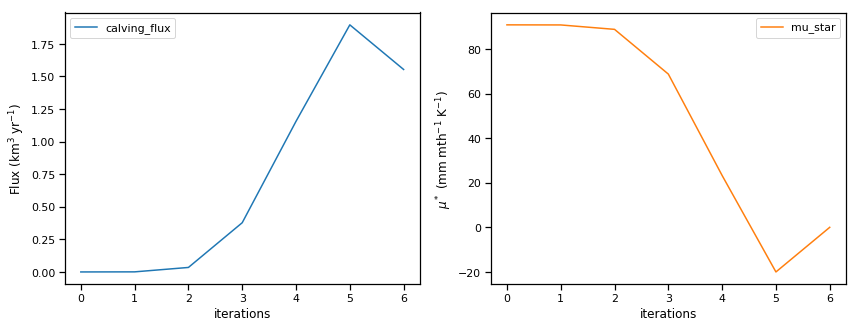

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
df[['calving_flux']].plot(ax=ax1);
ax1.set_ylabel('Flux (km$^3$ yr$^{-1}$)');
df[['mu_star']].plot(ax=ax2, color='C1');
ax2.set_ylabel('$\mu^*$ (mm mth$^{-1}$ K$^{-1}$)');

If this happens during the iteration, OGGM is going to set $\mu^*$ to zero and computes the corresponding flux (the maximal possible physical value). In this case, the calving law and OGGM disagree:

In [26]:
print('At iteration stop:')
print(df.iloc[-1])

At iteration stop:
calving_flux          1.553626
mu_star               0.000000
calving_law_flux      2.156726
width               775.030492
thick               571.201615
water_depth         487.177067
free_board           84.024549
Name: 6, dtype: float64


## Discussion 

We have shown that under certain assumptions, our method converges to an ice thickness consistent with the calving law. Of course, there are many uncertainties involved, and it is not our attempt to find the "true" calving flux here. See  [Recinos et al. (in review)](https://www.the-cryosphere-discuss.net/tc-2018-254/) for our motivations and a discussion about why it is crucial to include frontal ablation in regional ice thickness estimates.

## What's next?

You have several options from here:
- return to the [OGGM documentation](https://docs.oggm.org)
- explore other tutorials on the [OGGM-Edu](https://edu.oggm.org) platform.